<div style="font-family:Cambria; font-size:2em">Recommendation System on OTT Platforms</div>

<div style="font-family:Cambria; font-size:1.2em">Order:
<br />1. Genre Prediction
<br />2. Collaborative Filtering
<br />3. Plot Filtering
<br />4. Content-based Filtering
<br />5. Final Recommendation System (Hybrid)</div>

<div style="font-family:Cambria; font-size:1.2em">Installing required packages</div>

In [1]:
import sys
!{sys.executable} -m pip install scikit-surprise

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lakshmi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<div style="font-family:Cambria; font-size:1.5em">Reading OTT Platforms dataset and IMDB User Ratings dataset</div>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sb
import re
import gc

In [4]:
data=pd.read_csv("data/all_titles.csv")
data['title_index']=data.index
data.drop(["title_id"], axis=1, inplace=True)
data[:5]

,title,genres,content_type,runtime,directors,actors,content_rating,release_year,date_added,summary,platforms,title_index
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance",Series,< 30 minutes,Tomas Alfredson,"Lina Leandersson, Kåre Hedebrant, Per Ragnar, ...",R,2008,2021-03-04,A med student with a supernatural gift tries t...,Netflix,0
1,HOW TO BUILD A GIRL,Comedy,Movie,1-2 hour,Coky Giedroyc,"Cleo, Paddy Considine, Beanie Feldstein, Dónal...",R,2020,2021-03-04,"When nerdy Johanna moves to London, things get...",Netflix,1
2,The Con-Heartist,"Comedy, Romance",Movie,> 2 hrs,Mez Tharatorn,"Kathaleeya McIntosh, Nadech Kugimiya, Pimchano...",Unrated,2020,2021-03-03,After her ex-boyfriend cons her out of a large...,Netflix,2
3,Gleboka woda,Drama,Series,< 30 minutes,"Magdalena Lazarkiewicz, Kasia Adamik, Olga Cha...","Katarzyna Maciag, Piotr Nowak, Marcin Dorocins...",Unrated,2011,2021-03-03,A group of social welfare workers led by their...,Netflix,3
4,Only a Mother,Drama,Movie,1-2 hour,Alf Sjöberg,"Hugo Björne, Eva Dahlbeck, Ulf Palme, Ragnar F...",Unrated,1949,2021-03-03,An unhappily married farm worker struggling to...,Netflix,4


In [5]:
imdb=pd.read_csv("data/user_ratings.csv")
imdb[:5]

,reviewer,rating,title_index
0,raeldor-96879,9.0,3082
1,lizadeegan,10.0,3082
2,NinnaMali97,9.0,3082
3,dimitardimitrov-47886,10.0,3082
4,josh-29279,10.0,3082


<div style="font-family:Cambria; font-size:1.5em">Cleaning summaries (Used for Genre Prediction and Plot Filtering)</div>

<div style="font-family:Cambria; font-size:1.2em">Importing stop words and removing the puncutation, stop words, extra spaces, and converting all words to lower cases for each summary present in the dataset.</div>

In [6]:
from nltk.corpus import stopwords
stop_words_list=stopwords.words('english')

In [7]:
def clean_summary(x):
    x=re.sub("\s+", " ", re.sub("[^\w ]", " ", x)).lower()
    x=[word for word in x.split() if not word in stop_words_list]
    return ' '.join(x)

In [8]:
%%time
data['clean_summary']=data.summary.apply(clean_summary)
data.clean_summary

CPU times: user 1.52 s, sys: 6.04 ms, total: 1.53 s
Wall time: 1.53 s


0        med student supernatural gift tries cash abili...
1        nerdy johanna moves london things get hand rei...
2        ex boyfriend cons large sum money former bank ...
3        group social welfare workers led new director ...
4        unhappily married farm worker struggling care ...
                               ...                        
23528     merlin trains young orphan destined king england
23529    strong willed family struggles establish wild ...
23530                     welcome kirby world rude sketchy
23531           ryan discovers ability control giant robot
23532    rock imagination movers disney junior favorite...
Name: clean_summary, Length: 23533, dtype: object

<div style="font-family:Cambria; font-size:1.2em">Generating the document-index matrix for the summaries in the dataset</div>

In [9]:
# TF-IDF : Term Frequency and Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()

In [10]:
def makeTfidfDF(data):
    tfidf_data=tfidf.fit_transform(data.clean_summary)
    return pd.DataFrame(tfidf_data.todense(), columns=tfidf.get_feature_names(), \
                      index=data.index)

<div style="font-family:Cambria; font-size:1.2em">Creating MultiLabelBinarizer object which is used to generating binary matrices</div>

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [12]:
def makeBinaryDFs(data, columnName):
    return pd.DataFrame(mlb.fit_transform(data[columnName].apply(lambda x: re.split(",\s*", x))),
            columns=mlb.classes_, index=data.index)

<div style="font-family:Cambria; font-size:2em">Genre Prediction</div>

<div style="font-family:Cambria; font-size:1.2em">Aim: To predict the genres for the movies/series (that have missing genres) using the plot/summary of that movie/series.</div>

<div style="font-family:Cambria; font-size:1.2em">Reducing to 10 genres</div>

In [13]:
new_genre_names={
    "Cooking & Food":"Drama",
    "Family":"Family",
    "Survival":"Thriller",
    "Science Fiction":"Fiction",
    "Late Night":"Thriller",
    "Documentaries":"Documentary",
    "Anthology":"Arts and Culture",
    "International":"Other",
    "Thriller":"Thriller",
    "Travel":"Action",
    "Action":"Action",
    "Teen":"Drama",
    "LGBTQ":"Drama",
    "Biographical":"Documentary",
    "Comedy":"Comedy",
    "Animals & Nature":"Other",
    "Documentary":"Documentary",
    "Coming of Age":"Drama",
    "Drama":"Drama",
    "Sketch Comedy":"Comedy",
    "Concert Film":"Arts and Culture",
    "Talk Show":"Other",
    "Fantasy":"Fiction",
    "Western":"Arts and Culture",
    "Entertainment":"Comedy",
    "Animation":"Fiction",
    "Romantic Comedy":"Comedy",
    "Series":"Other",
    "Lifestyle & Culture":"Arts and Culture",
    "Historical":"Documentary",
    "Variety":"Other",
    "War":"Action",
    "Stand Up":"Comedy",
    "Science & Technology":"Fiction",
    "Kids":"Family",
    "Adult":"Other",
    "Black Stories":"Other",
    "Game Shows":"Other",
    "Medical":"Drama",
    "Musical":"Arts and Culture",
    "Sitcom":"Comedy",
    "Biography":"Documentary",
    "Sport":"Action",
    "Lifestyle":"Arts and Culture",
    "and Culture":"Arts and Culture",
    "Sci-Fi":"Fiction",
    "Military and War":"Action",
    "Latino":"Other",
    "Talk-Show":"Other",
    "History":"Documentary",
    "Docuseries":"Documentary",
    "Classics":"Drama",
    "Spy/Espionage":"Thriller",
    "Suspense":"Thriller",
    "Game-Show":"Other",
    "Music Videos and Concerts":"Arts and Culture",
    "News":"Other",
    "Sports":"Action",
    "Anime":"Fiction",
    "Crime":"Thriller",
    "Police/Cop":"Thriller",
    "Superhero":"Action",
    "Music":"Arts and Culture",
    "Adventure":"Action",
    "Soap Opera / Melodrama":"Drama",
    "Game Show / Competition":"Other",
    "Short":"Other",
    "Faith and Spirituality":"Arts and Culture",
    "Fitness":"Action",
    "Action-Adventure":"Action",
    "Movies":"Other",
    "Disaster":"Action",
    "Talk Show and Variety":"Other",
    "Reality":"Other",
    "Film-Noir":"Drama",
    "Arts":"Arts and Culture",
    "LGBTQ+":"Drama",
    "Mystery":"Thriller",
    "Arthouse":"Arts and Culture",
    "Buddy":"Drama",
    "Dance":"Arts and Culture",
    "Special Interest":"Other",
    "Horror":"Horror",
    "Young Adult Audience":"Drama",
    "Romance":"Comedy",
    "Parody":"Comedy",
    "Health & Wellness":"Arts and Culture",
    "TV Shows":"Other",
    "Unscripted":"Other",
    "Adult Animation":"Fiction",
    "Reality-TV":"Other",
    "Cartoons":"Fiction"
    }

In [14]:
def clean_genres(x):
    genres=[]
    for genre in re.split(",\s+", x):
        if genre in new_genre_names:
            genres.append(new_genre_names[genre])
        else:
            genres.append(genre)
    genres = sorted(set(genres))
    return ', '.join(genres)

data['clean_genres']=data.genres.apply(clean_genres)

<div style="font-family:Cambria; font-size:1.2em">List of clean genres present</div>

In [15]:
genres=[]
for row in data.clean_genres.str.split(", "):
    genres.extend(row)
print(set(genres))

{'Horror', 'Comedy', 'Fiction', 'Unknown', 'Action', 'Other', 'Family', 'Thriller', 'Arts and Culture', 'Drama', 'Documentary'}


<div style="font-family:Cambria; font-size:1.2em">Number of genres which are Unknown</div>

In [16]:
data_without_genres=data[data.genres=="Unknown"]
data_without_genres.shape

(25, 14)

In [17]:
data_with_genres=data[data.genres!="Unknown"]
data_with_genres.shape

(23508, 14)

<div style="font-family:Cambria; font-size:1.2em">Creating a binary matrix for genres. These represent the classes for this classification problem.</div>

In [18]:
classes=makeBinaryDFs(data_with_genres, "clean_genres")
classes.head()

,Action,Arts and Culture,Comedy,Documentary,Drama,Family,Fiction,Horror,Other,Thriller
0,0,0,1,0,1,0,1,1,0,1
1,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


<div style="font-family:Cambria; font-size:1.2em">The words from the summaries (the TFIDF scores) represent the features for this classification problem.</div>

In [19]:
%%time
features=makeTfidfDF(data_with_genres)

CPU times: user 490 ms, sys: 490 ms, total: 980 ms
Wall time: 1.09 s


In [20]:
features.shape, classes.shape

((23508, 41094), (23508, 10))

<div style="font-family:Cambria; font-size:1.2em">Importing required packages from this classification problem</div>

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, precision_score, hamming_loss

In [22]:
random_state_value=9

<div style="font-family:Cambria; font-size:1.2em">Splitting the data_with_genres into train and test set</div>

In [23]:
%%time
features_train, features_test, classes_train, classes_test=train_test_split(\
        features, classes, test_size=0.2, random_state=random_state_value)

CPU times: user 1.26 s, sys: 2.69 s, total: 3.95 s
Wall time: 6.49 s


<div style="font-family:Cambria; font-size:1.2em">Models</div>

In [24]:
models=[OneVsRestClassifier(LogisticRegression(random_state=random_state_value, solver='liblinear', \
                                              multi_class="ovr")),
       OneVsRestClassifier(BernoulliNB()),
       OneVsRestClassifier(MultinomialNB()),
       OneVsRestClassifier(SGDClassifier(random_state=random_state_value)),
       OneVsRestClassifier(LinearSVC(multi_class="ovr", random_state=random_state_value))]
model_names=['Logistic Regression', 'Bernoulli Naive Bayes', 'Multinomial Naive Bayes', \
            'Stochastic Gradient Descent', 'Linear Support Vector Classification']
precision_scores=[]
hamming_loss_values=[]
classification_reports=[]

<div style="font-family:Cambria; font-size:1.2em">Training, testing, evaluating models</div>

In [25]:
%%time
for i in range(len(models)):
    print(f"Procedure started with {model_names[i]}")
    predictions=models[i].fit(features_train, classes_train).predict(features_test)
    precision_scores.append(precision_score(classes_test, predictions, average="micro"))
    hamming_loss_values.append(hamming_loss(classes_test, predictions))
    classification_reports.append(classification_report(classes_test, predictions, \
                            target_names=classes.columns, zero_division=0, output_dict=True))
    print(f"Procedure done with {model_names[i]}")

Procedure started with Logistic Regression
Procedure done with Logistic Regression
Procedure started with Bernoulli Naive Bayes
Procedure done with Bernoulli Naive Bayes
Procedure started with Multinomial Naive Bayes
Procedure done with Multinomial Naive Bayes
Procedure started with Stochastic Gradient Descent
Procedure done with Stochastic Gradient Descent
Procedure started with Linear Support Vector Classification
Procedure done with Linear Support Vector Classification
CPU times: user 9min 10s, sys: 8min 36s, total: 17min 46s
Wall time: 1h 56s


<div style="font-family:Cambria; font-size:1.2em">Visualizing the Results</div>

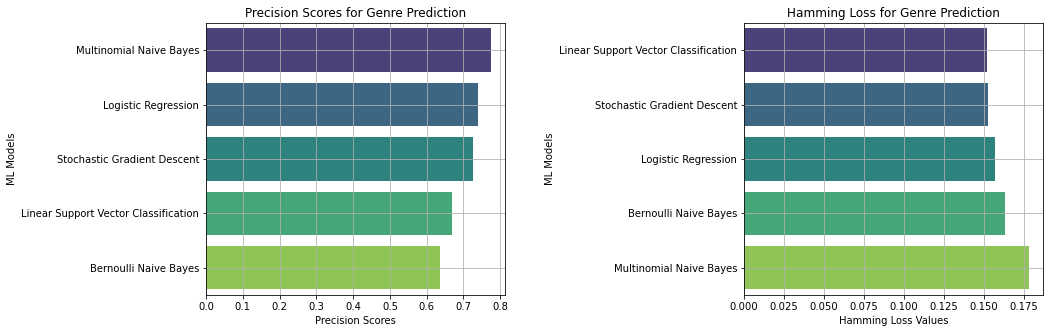

In [26]:
fig, ax=plot.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.8, 'hspace': 0.4})

_=pd.DataFrame([precision_scores, model_names]).T
_.columns=['Precision', 'Model']
sb.barplot(ax=ax[0], x='Precision', y='Model', data=_.sort_values(by='Precision', ascending=False), \
           palette='viridis')
ax[0].set_ylabel("ML Models")
ax[0].set_xlabel("Precision Scores")
ax[0].set_title("Precision Scores for Genre Prediction")
ax[0].grid()

_=pd.DataFrame([hamming_loss_values, model_names]).T
_.columns=['Hamming Loss', 'Model']
sb.barplot(ax=ax[1], x='Hamming Loss', y='Model', data=_.sort_values(by='Hamming Loss'), \
           palette='viridis')
ax[1].set_ylabel("ML Models")
ax[1].set_xlabel("Hamming Loss Values")
ax[1].set_title("Hamming Loss for Genre Prediction")
ax[1].grid()

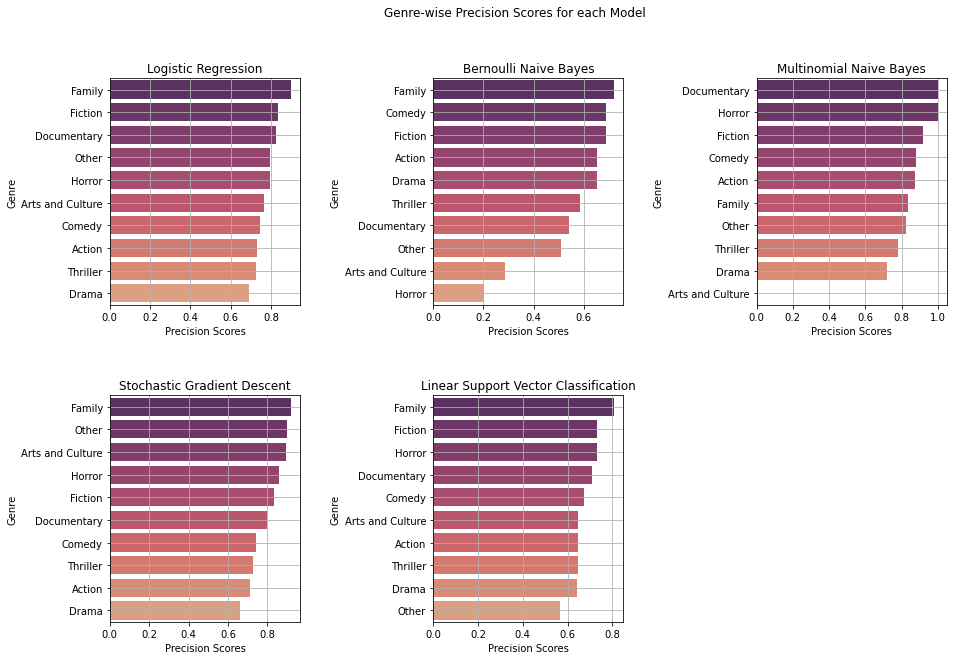

In [27]:
fig, ax=plot.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.7, 'hspace': 0.4})

for i in range(len(model_names)):
    _=pd.DataFrame([[genre, classification_reports[i][genre]['precision']] for genre in \
                  list(classification_reports[i].keys())[:10]], columns=['Genre', 'Precision'])
    #plot.figure(figsize=(4, 5))
    ax_i=ax.flatten()[i]
    sb.barplot(ax=ax_i, x='Precision', y='Genre', palette='flare_r', \
               data=_.sort_values(by='Precision', ascending=False))
    ax_i.set_ylabel("Genre")
    ax_i.set_xlabel("Precision Scores")
    ax_i.set_title(model_names[i])
    ax_i.grid()
fig.suptitle("Genre-wise Precision Scores for each Model")
fig.delaxes(ax[1][2])

<div style="font-family:Cambria; font-size:1.2em"><b>Logisitic Regression</b> model is chosen</div>

In [28]:
i=model_names.index('Logistic Regression')

<div style="font-family:Cambria; font-size:1.2em">Predicting genres for those content that have missing genres</div>

In [29]:
%%time
test=tfidf.transform(data_without_genres.summary)
test=pd.DataFrame(test.todense(), columns=tfidf.get_feature_names(), \
                      index=data_without_genres.index)

CPU times: user 17.4 ms, sys: 8.05 ms, total: 25.4 ms
Wall time: 32.2 ms


In [30]:
predictions=models[i].predict(test)
predictions=pd.DataFrame(predictions, columns=classes.columns, index=data_without_genres.index)
predictions['title_index']=predictions.index

In [31]:
# For those rows having all zeroes, put other=1.
results=pd.merge(predictions, data[['title_index', 'title', 'release_year', 'content_type']], on='title_index')
results.loc[0]

Action                                   1
Arts and Culture                         0
Comedy                                   0
Documentary                              0
Drama                                    0
Family                                   0
Fiction                                  0
Horror                                   0
Other                                    0
Thriller                                 1
title_index                            169
title               Partners: The Movie IV
release_year                          2017
content_type                         Movie
Name: 0, dtype: object

<div style="font-family:Cambria; font-size:1.2em">The internet shows Action, Crime, Mystery, Suspense genres for this movie 'Partners: The Movie IV. We've categoried Mystery, Crime, Suspense under Thriller. Our model predicted Action and Thriller for this movie. 
<br /><a href="https://dramacool.news/asian-wiki/partners-the-movie-iv.html">https://dramacool.news/asian-wiki/partners-the-movie-iv.html</a></div>

<div style="font-family:Cambria; font-size:1.2em">For movies/series where no genre is predicted, set it to Other genre</div>

In [32]:
results.loc[results.iloc[:, range(10)].T.sum()==0, 'Other']=1

<div style="font-family:Cambria; font-size:1.2em">Update genres in the original dataset</div>

In [33]:
def updateGenres(x):
    row=x.iloc[range(10)]==1
    genres=', '.join(list(row[row].index))
    data.loc[x.title_index, 'genres']=genres
    
results.apply(updateGenres, axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
dtype: object

<div style="font-family:Cambria; font-size:1.2em">Checking the updated genres</div>

In [34]:
data.loc[results.title_index, 'genres']

169            Action, Thriller
201                      Action
233                       Drama
328               Comedy, Drama
579                       Drama
753      Comedy, Drama, Fiction
1124                      Drama
1149                     Comedy
1185                      Other
1549              Comedy, Drama
1893                      Other
1948                Documentary
2306                     Action
2327            Family, Fiction
2800                      Drama
3031                      Other
3095                      Other
3534                      Drama
4528            Family, Fiction
5207    Action, Drama, Thriller
5342                    Fiction
5502                      Other
7382                      Other
7432                      Other
8689                     Action
Name: genres, dtype: object

<div style="font-family:Cambria; font-size:1.2em">The genres are updated!</div>

<div style="font-family:Cambria; font-size:1.2em">Delete unrequired variables</div>

In [35]:
del data_with_genres, classes, features, features_test, features_train, \
    classes_test, classes_train, data_without_genres, predictions, models, \
    model_names, precision_scores, hamming_loss_values, classification_reports, \
    test, results
gc.collect()

6668

<div style="font-family:Cambria; font-size:2em">Collaborative Filtering</div>

<div style="font-family:Cambria; font-size:1.2em">Aim: To recommend movies/series to the user based on the ratings of the user to different movies/series.</div>

<div style="font-family:Cambria; font-size:1.2em">Distribution of ratings</div>

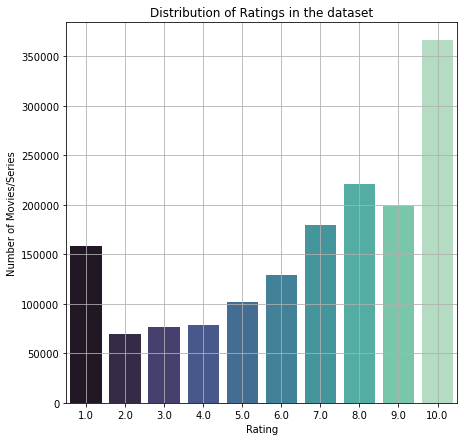

In [36]:
plot.figure(figsize=(7, 7))
sb.countplot(data=imdb, x='rating', palette='mako')
plot.ylabel("Number of Movies/Series")
plot.xlabel("Rating")
plot.title("Distribution of Ratings in the dataset")
plot.grid()

<div style="font-family:Cambria; font-size:1.2em">Generating a reviewer_id</div>

In [37]:
reviewer=imdb.reviewer.value_counts().reset_index()
reviewer['reviewer_id']=reviewer.index
reviewer.drop(['reviewer'], axis=1, inplace=True)
reviewer.columns=['reviewer', 'reviewer_id']
reviewer[:5], reviewer.shape

(         reviewer  reviewer_id
 0     SnoopyStyle            0
 1         kosmasp            1
 2  Leofwine_draca            2
 3   jboothmillard            3
 4  nogodnomasters            4,
 (629611, 2))

<div style="font-family:Cambria; font-size:1.2em">Merging this with IMDB</div>

In [38]:
imdb=pd.merge(imdb, reviewer)
imdb[:5]

,reviewer,rating,title_index,reviewer_id
0,raeldor-96879,9.0,3082,80644
1,raeldor-96879,8.0,1848,80644
2,raeldor-96879,9.0,1210,80644
3,lizadeegan,10.0,3082,488222
4,NinnaMali97,9.0,3082,246129


<div style="font-family:Cambria; font-size:1.2em">Importing required packages for collaborative filtering</div>

In [39]:
from surprise import Dataset, Reader, SVD, accuracy, SVDpp, NMF, CoClustering, SlopeOne
from surprise.model_selection import train_test_split, cross_validate

<div style="font-family:Cambria; font-size:1.2em">Creating the Reader and Dataset object</div>

In [40]:
%%time
reader=Reader(rating_scale=(1, 10))
imdb_data=Dataset.load_from_df(imdb[['reviewer_id', 'title_index', \
                 'rating']], reader)

CPU times: user 879 ms, sys: 58.2 ms, total: 937 ms
Wall time: 937 ms


In [41]:
random_state_value=18

<div style="font-family:Cambria; font-size:1.2em">Models</div>

In [42]:
models=[SVD(n_epochs=10, random_state=random_state_value),
       SVDpp(n_epochs=10, random_state=random_state_value),
       NMF(n_epochs=10, random_state=random_state_value),
       SlopeOne(),
       CoClustering(n_epochs=10, random_state=random_state_value)]
model_names=['Singular Value Decomposition', 'Singular Value Decomposition++', 'Non-negative Matrix Factorization', \
             'Slope One', 'Co-Clustering']
measures=['RMSE', 'MAE']
cross_val_results=[]

In [ ]:
%%time
for i in range(len(models)):
    print(f"Started with {model_names[i]}")
    cross_val_results.append(cross_validate(models[i], imdb_data, measures=measures, cv=10))
    print(f"Finished with {model_names[i]}")

Started with Singular Value Decomposition
Finished with Singular Value Decomposition
Started with Singular Value Decomposition++


<div style="font-family:Cambria; font-size:1.2em">Visualizing the cross-validation results</div>

In [ ]:
rmse=pd.DataFrame([cross_val_results[i]['test_rmse'] for i in range(len(model_names))]).T
rmse.columns=model_names
plot.figure(figsize=(16, 4))
rmse_plot=plot.boxplot(rmse, vert=0, patch_artist=True)
#rmse_plot=sb.boxplot(data=rmse, orient='h', palette=['powderblue', 'pink', 'palegreen', 'peachpuff', 'lavender'])
plot.ylabel("Collaborative Filtering Models")
plot.xlabel("Root Mean Square Error (RMSE)")
plot.yticks(range(1, 6), labels=model_names)
plot.title("Collaborative Filtering - Cross Validation Results")
plot.grid()
colors=['powderblue', 'pink', 'palegreen', 'peachpuff', 'lavender']
for patch, color in zip(rmse_plot['boxes'], colors):
    patch.set_facecolor(color)
    
mae=pd.DataFrame([cross_val_results[i]['test_mae'] for i in range(len(model_names))]).T
mae.columns=model_names
plot.figure(figsize=(16, 4))
mae_plot=plot.boxplot(mae, vert=0, patch_artist=True)
#rmse_plot=sb.boxplot(data=rmse, orient='h', palette=['powderblue', 'pink', 'palegreen', 'peachpuff', 'lavender'])
plot.ylabel("Collaborative Filtering Models")
plot.xlabel("Mean Absolute Error (MAE)")
plot.yticks(range(1, 6), labels=model_names)
plot.title("Collaborative Filtering - Cross Validation Results")
plot.grid()
colors=['powderblue', 'pink', 'palegreen', 'peachpuff', 'lavender']
for patch, color in zip(mae_plot['boxes'], colors):
    patch.set_facecolor(color)

<div style="font-family:Cambria; font-size:1.2em">Choosing SVD as it produces the best results</div>

<div style="font-family:Cambria; font-size:1.2em">Splitting the user ratings dataset into train set and test set</div>

In [ ]:
%%time
train_set, test_set=train_test_split(imdb_data, test_size=.20)

<div style="font-family:Cambria; font-size:1.2em">Trying different parameter values for SVD</div>

In [ ]:
svd_models=[SVD(random_state=random_state_value), # Default - factors=100, epochs=20
            SVD(n_epochs=10, random_state=random_state_value), # Factors=100, epochs=10
            SVD(n_factors=50, random_state=random_state_value), # Factors=50, epochs=20
            SVD(n_factors=50, n_epochs=10, random_state=random_state_value), # Factors=50, epochs=10
            SVD(n_factors=250, n_epochs=10, random_state=random_state_value), # Factors=250, epochs=10
            SVD(n_factors=250, n_epochs=20, random_state=random_state_value), # Factors=250, epochs=20
            SVD(n_epochs=50, random_state=random_state_value), # Factors=100, epochs=50
            SVD(n_factors=250, n_epochs=50, random_state=random_state_value)] # Factors=100, epochs=50
svd_model_params=[{'factors':100, 'epochs':20}, {'factors':100, 'epochs':10}, {'factors':50, 'epochs':20},
                {'factors':50, 'epochs':10}, {'factors':250, 'epochs':10}, {'factors':250, 'epochs':20},
                {'factors':100, 'epochs':50}, {'factors':250, 'epochs':50}]
predictions=[]
rmse_values=[]
mae_values=[]

In [ ]:
%%time
for i in range(len(svd_models)):
    print("Started with SVD With Factors :", svd_model_params[i]['factors'], \
          " and Epochs :", svd_model_params[i]['epochs'])
    predictions.append(svd_models[i].fit(train_set).test(test_set))
    rmse_values.append(accuracy.rmse(predictions[i]))
    mae_values.append(accuracy.mae(predictions[i]))
    print("Finished with this model")

In [ ]:
measures_df=pd.DataFrame(svd_model_params)
measures_df['RMSE']=rmse_values
measures_df['MAE']=mae_values
measures_df['Params']=measures_df.apply(lambda x:f'n_f : {x.factors}\nn_e : {x.epochs}', axis=1)
measures_df

In [ ]:
plot.figure(figsize=(18, 5))
sb.barplot(x='RMSE', y='Params', data=measures_df.sort_values(by='RMSE'), \
           palette='mako_r')
plot.ylabel("SVD Parameter Values")
plot.xlabel("RMSE Score")
plot.xticks(np.arange(2, 3, 0.25))
plot.title("RMSE Score For Different Values of Parameters for SVD")
plot.grid()

plot.figure(figsize=(18, 5))
sb.barplot(x='MAE', y='Params', data=measures_df.sort_values(by='MAE'), \
           palette='mako_r')
plot.ylabel("SVD Parameter Values")
plot.xlabel("MAE Score")
plot.xticks(np.arange(0, 2, 0.25))
plot.title("MAE Score For Different Values of Parameters for SVD")
plot.grid()

<div style="font-family:Cambria; font-size:1.2em">SVD works better with Factors=100, Epochs=50. We're not choosing SVD with Factors=250, Epochs=50 in order to not overfit the same.</div>

In [ ]:
i=svd_model_params.index({'factors':100, 'epochs':50})

In [ ]:
svd=svd_models[i]
predictions=predictions[i]

In [ ]:
def predictRating(title_id, reviewer_id):
    return svd.predict(uid=reviewer_id, iid=title_id).est

In [ ]:
def predictThisUserRatings(reviewer_id, threshold=7500):
    # Indices for titles from the OTT dataset which are not yet rated by this user.
    next_indices=set(range(len(data)))-set(imdb[imdb.reviewer_id==reviewer_id].title_index)
    # The prediction ratings for the titles in the above indices.
    ratings=data.loc[next_indices, 'title_index'].apply(predictRating, args=(reviewer_id, ))
    return ratings.sort_values(ascending=False).index[:threshold] 

<div style="font-family:Cambria; font-size:1.2em">Visualizing the results for SVD</div>

<div style="font-family:Cambria; font-size:1.2em">User-Content matrix for 5 users and 5 titles from our dataset</div>

In [ ]:
new_data=pd.DataFrame()
uid=[10, 18,  2,  5, 16]
cid=[8723, 8380, 6127, 9, 9195]
for i in uid:
    for j in cid:
        row=imdb[(imdb.reviewer_id==i) & (imdb.title_index==j)]
        if row.shape[0]==0:
            new_data.loc[i, data[data.title_index==j].title[j]]=f"P : {svd.predict(uid=i, iid=j).est}"
        else:
            new_data.loc[i, data[data.title_index==j].title[j]]=float(row.rating)
new_data

<div style="font-family:Cambria; font-size:1.2em">The next 5 movies the user 'Leofwine_draca' would enjoy based on ratings provided by this user.</div>

In [ ]:
#imdb[imdb.reviewer_id==2].reviewer
next_indices=set(range(len(data)))-set(imdb[imdb.reviewer_id==2].title_index)
# The prediction ratings for the titles in the above indices.
ratings=data.loc[next_indices, 'title_index'].apply(predictRating, args=(2, ))
ratings=ratings.sort_values(ascending=False)
next_indices=ratings.index[:5]
top5=data.loc[next_indices][['title', 'content_type', 'release_year', 'platforms']]
top5['predicted_rating']=ratings[:5]
top5

<div style="font-family:Cambria; font-size:2em">Plot and Content-based Filtering</div>

<div style="font-family:Cambria; font-size:1.2em">Aim: To recommend movies/series based on the plot and other content features like genres, directors, actors and content ratings of a certain movie/series to a particular user.</div>

<div style="font-family:Cambria; font-size:1.2em">Both the plot and content-based Filtering are combined and are performed on the top 5000 (threshold) results returned by the collaborative filtering. This is also the <b>Hybrid</b> recommendation system.</div>

<div style="font-family:Cambria; font-size:1.2em">TFIDF values are between 0 and 1, so we're not performing normalization for them.</div>

<div style="font-family:Cambria; font-size:1.2em">Some data analysis for plot-based filtering</div>

In [ ]:
tfidf_data=makeTfidfDF(data)
tfidf_data=tfidf_data.mean().sort_values(ascending=False)[:10].reset_index()
tfidf_data.rename(columns={"index":"Words", 0:"TF-IDF Score"}, inplace=True)

In [ ]:
plot.figure(figsize=(7, 5))
sb.barplot(y='Words', x='TF-IDF Score', data=tfidf_data, palette='Greens_r')
plot.title("Top 10 Important Words from the Plots in the dataset")
plot.grid()

<div style="font-family:Cambria; font-size:1.2em">Some data analysis for content-based filtering</div>

In [ ]:
fig, ax=plot.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3, 'hspace': 0.4})

words=[]
for row in data.genres:
    words.extend(re.split(",\s*", row))
words=pd.Series(words).value_counts().reset_index()
words.rename(columns={"index":"words", 0:"count"}, inplace=True)

plot.figure(figsize=(7, 5))
sb.barplot(ax=ax[0], x='words', y='count', data=words[:10], palette='Blues_r')
ax[0].set_ylabel("Number of Movies/Series")
ax[0].set_xlabel("Genres")
ax[0].set_xticklabels(labels=words.words[:10], rotation=90)
ax[0].set_title("Top 10 Genres with most Content")
ax[0].grid()

words=data.content_rating.value_counts().reset_index()
words.rename(columns={"index":"words", "content_rating":"count"}, inplace=True)

plot.figure(figsize=(6, 4))
sb.barplot(ax=ax[1], x='words', y='count', data=words[:10], palette='Blues_r')
ax[1].set_ylabel("Number of Movies/Series")
ax[1].set_xlabel("Content ratings")
ax[1].set_xticklabels(labels=words.words[:10], rotation=90)
ax[1].set_title("Top 10 content ratings with most Content")
ax[1].grid()

In [ ]:
fig, ax=plot.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3, 'hspace': 0.4})

words=[]
for row in data[data.actors!="Unknown"].actors:
    words.extend(re.split(",\s*", row))
words=pd.Series(words).value_counts().reset_index()
words.rename(columns={"index":"words", 0:"count"}, inplace=True)

plot.figure(figsize=(7, 5))
sb.barplot(ax=ax[1], x='words', y='count', data=words[1:11], palette='Blues_r')
ax[1].set_ylabel("Number of Movies/Series")
ax[1].set_xlabel("Cast & Crew")
ax[1].set_xticklabels(labels=words.words[:10], rotation=90)
ax[1].set_title("Top 10 Cast & Crew with most Content")
ax[1].grid()

words=[]
for row in data[data.directors!="Unknown"].directors:
    words.extend(re.split(",\s*", row))
words=pd.Series(words).value_counts().reset_index()
words.rename(columns={"index":"words", 0:"count"}, inplace=True)

plot.figure(figsize=(7, 5))
sb.barplot(ax=ax[0], x='words', y='count', data=words[:10], palette='Blues_r')
ax[0].set_ylabel("Number of Movies/Series")
ax[0].set_xlabel("Directors")
ax[0].set_xticklabels(labels=words.words[:10], rotation=90)
ax[0].set_title("Top 10 Directors with most Content")
ax[0].grid()

In [ ]:
data[data.actors=="Maggie Binkley"][['title', 'genres', 'content_type', 'platforms']][:10]

In [ ]:
data[data.actors=="Pinto Colvig"][['title', 'genres', 'content_type', 'platforms']][:10]

In [ ]:
data[data.directors=="Mark Knight"][['title', 'genres', 'content_type', 'platforms']][:10]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

<div style="font-family:Cambria; font-size:1.2em">Build the recommender function</div>

In [ ]:
def generateMatrices(data):
    binary=pd.concat([makeBinaryDFs(data, 'genres'), makeBinaryDFs(data, 'directors'), \
              makeBinaryDFs(data, 'actors'), makeBinaryDFs(data, 'content_rating'), \
              makeTfidfDF(data)], axis=1)
    return pd.DataFrame(cosine_similarity(binary), index=binary.index, columns=binary.index)

In [ ]:
def getRecommendations(data, title, row_id, n):
    cosine_similarities=generateMatrices(data)
    results=cosine_similarities[row_id].sort_values(ascending=False)
    similar=data.loc[results[results.index!=row_id].index[:n]]
    return similar

In [ ]:
def recommender(reviewer, title, n=5):
    _id=imdb[imdb.reviewer==reviewer].reviewer_id.unique()
    row_id=data[data.title==title].index
    if len(_id)==0:
        return "No such reviewer"
    if row_id.shape[0]<1:
        return "No such title"
    reviewer_id=_id[0]
    indices=predictThisUserRatings(reviewer_id)
    if row_id[0] not in indices:
        indices=list(indices)+[row_id[0]]
    else:
        indices=list(indices)
    results=getRecommendations(data.loc[list(indices)], title, row_id[0], n)
    return results[['title', 'genres', 'content_type', 'directors', \
                    'actors', 'content_rating', 'release_year', \
                    'summary', 'platforms']]

<div style="font-family:Cambria; font-size:1.2em">Few hybrid recommendation exmaples</div>

In [ ]:
%%time
recommender("arishsankar", "Back to the Future")

In [ ]:
%%time
recommender("SnoopyStyle", "Jujutsu Kaisen")

In [ ]:
recommender("SnoopyStyle", "Friends")